<a href="https://colab.research.google.com/github/askery/tensorflow2-examples/blob/main/CNN_TF2_denoise_MNIST_like_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------
# Author: Askery Canabarro
# -------------------------
# Inspiration: https://www.machinecurve.com/index.php/2019/12/20/building-an-image-denoiser-with-a-keras-autoencoder-neural-network/
# 
# ****
# 1- This code demonstrates how to use TensorFlow 2.0 for a simple denoise problem.
# 2- We pass noisy images as input (X = y + factor*noise) and pure images as output (y). So, it is a typical supervised approach.
# 3- However, it is trick to solve without GPU acceleration. This is why TF is a increadible tool.
# 4- You are encouraged to try sklearn-learn MLP and RF (takes a lot of time) algo to verify their disadavatages.
# 5- We show comparison with sklearn MLP.
# ****

In [2]:
# STEP 0: Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
print(tf.__version__)

2.4.1


In [3]:
# STEP 1: Load the data (choose a MNIST-like dataset)
(X_train,y_train),(X_test,y_test) =tf.keras.datasets.mnist.load_data()
#(X_train,y_train),(X_test,y_test) =tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# STEP 1a: Inspect type and shapes.
print ("Data type     ", type(X_train)) # numpy array. Nice!
print ("Xtrain shape: ", X_train.shape) # 60000 examples of 28 x 28 = 784 arrays
print ("Xtest  shape: ", X_test.shape)  # 10000 examples of 28 x 28 = 784 arrays
print ("ytrain shape: ", y_train.shape)
print ("ytest  shape: ", y_test.shape)
print ("Min/Max X[0]: ", X_train[0].min(), "..", X_train[0].max()) # [0,255]]
print ("Pixels (int): ", type(X_train[0].min()), type(X_train[0].max())) # Int 

Data type      <class 'numpy.ndarray'>
Xtrain shape:  (60000, 28, 28)
Xtest  shape:  (10000, 28, 28)
ytrain shape:  (60000,)
ytest  shape:  (10000,)
Min/Max X[0]:  0 .. 255
Pixels (int):  <class 'numpy.uint8'> <class 'numpy.uint8'>


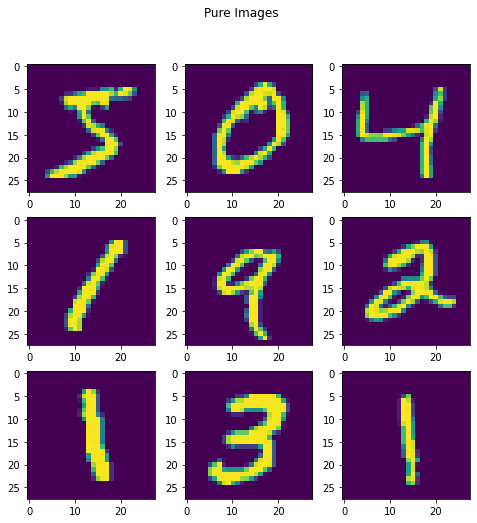

In [5]:
# STEP 1b: Explanatory Data Analysis (EDA)
color_mp = 'viridis' # or 'gray' >> set color map for all images from now on <<
## 3x3 grid of images
plt.figure(figsize=(8,8))	
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=color_mp)
plt.suptitle('Pure Images')
plt.show()

In [6]:
# STEP 1c: Pre-processing
# reshape to be [#samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test  = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Pixels from integer in range (0,255) to float from (0.,1.). It helps convergence!
X_train = X_train/255.
X_test  = X_test/255.

In [7]:
# STEP 1d: ReInspect for a sanity check
print ("Data type     ", type(X_train)) # numpy array. Nice!
print ("Xtrain shape: ", X_train.shape) # 60000 examples, 28 x 28 = 784 shape
print ("Xtest  shape: ", X_test.shape)  # 10000 examples, 28 x 28 = 784 shape
print ("ytrain shape: ", y_train.shape)
print ("ytest  shape: ", y_test.shape)
print ("Min/Max X[0]: ", X_train[0].min(), "..", X_train[0].max()) # [0,255]]
print ("Pixels (int): ", type(X_train[0].min()), type(X_train[0].max())) # Int 

Data type      <class 'numpy.ndarray'>
Xtrain shape:  (60000, 28, 28, 1)
Xtest  shape:  (10000, 28, 28, 1)
ytrain shape:  (60000,)
ytest  shape:  (10000,)
Min/Max X[0]:  0.0 .. 1.0
Pixels (int):  <class 'numpy.float64'> <class 'numpy.float64'>


In [8]:
# STEP 1e: Add noise
## Noisy images will be pure images (Xtrain and Xtest) + noise_factor*(Corresponding Noise Arrays)
nf = 0.3 # noise_factor

noisy_Xtrain = (1-nf)*X_train + nf * np.random.normal(0, 1, X_train.shape)
noisy_Xtest  = (1-nf)*X_test  + nf * np.random.normal(0, 1, X_test.shape)

#for i in range(len(X_train)):
#  noisy_Xtrain[i] = (1-nf)*X_train[i] + nf * np.random.normal(0,1,(28,28,1))
#noise_for_Xtrain =  np.random.normal(0, 1, X_train.shape)
#noise_for_Xtest  =  np.random.normal(0, 1, X_test.shape)
noisy_Xtrain.shape

(60000, 28, 28, 1)

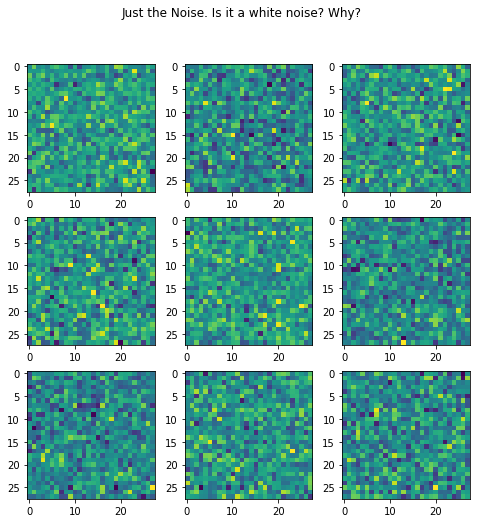

In [9]:
# STEP 1f: How noise looks like? Is it a white noise? 
## 3x3 grid of noisy images
plt.figure(figsize=(8,8))	
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  #plt.imshow(noise_for_Xtrain[i].reshape((28,28)), cmap=color_mp)
  plt.imshow(np.random.normal(0,1,(28,28)), cmap=color_mp)
plt.suptitle('Just the Noise. Is it a white noise? Why?')
plt.show()

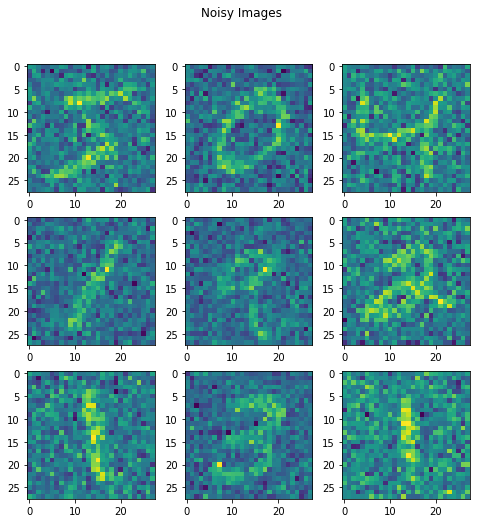

In [10]:
# STEP 1g: Explanatory Data Analysis (EDA) - noisy images
## 3x3 grid of noisy images
plt.figure(figsize=(8,8))	
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(noisy_Xtrain[i].reshape((28,28)), cmap=color_mp)
plt.suptitle('Noisy Images')
plt.show()

In [11]:
# STEP 2: benchmark with sklearn MLP
batch_size=128
from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(hidden_layer_sizes=(100,100), verbose=True, batch_size=batch_size)

X  = noisy_Xtrain.reshape((-1,28*28)) # input : noisy images
y  = X_train.reshape((-1,28*28))      # output: pure images

print("Training MLP...")
MLP.fit(X,y)

Training MLP...
Iteration 1, loss = 0.02006081
Iteration 2, loss = 0.01243142
Iteration 3, loss = 0.01130885
Iteration 4, loss = 0.01073123
Iteration 5, loss = 0.01035584
Iteration 6, loss = 0.01008119
Iteration 7, loss = 0.00985734
Iteration 8, loss = 0.00966432
Iteration 9, loss = 0.00950133
Iteration 10, loss = 0.00936040
Iteration 11, loss = 0.00925028
Iteration 12, loss = 0.00915274
Iteration 13, loss = 0.00905371
Iteration 14, loss = 0.00896827
Iteration 15, loss = 0.00890289
Iteration 16, loss = 0.00884355
Iteration 17, loss = 0.00878772
Iteration 18, loss = 0.00874583
Iteration 19, loss = 0.00869559
Iteration 20, loss = 0.00865216
Iteration 21, loss = 0.00861772
Iteration 22, loss = 0.00857952
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(activation='relu', alpha=0.0001, batch_size=128, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

In [12]:
#from sklearn.ensemble import RandomForestRegressor
#print("Training RF...")
#RF = RandomForestRegressor()
#RF.fit(X,y)

In [13]:
# STEP 2.1: build the model (Sequential API)  
kernel_init = 'glorot_uniform'#'he_uniform'
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_init , input_shape=X_train[0].shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_init))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer=kernel_init ))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', kernel_initializer=kernel_init ))
model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 47,425
Trainable params: 47,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
# STEP 2.1a: optimization and loss parameters and more
opt  = "adam" #"Nadam"
cost = "binary_crossentropy"

model.compile(optimizer=opt, 
                   loss=cost)

# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=13,restore_best_weights=False)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose = 1 )

In [15]:
#fitting model...
r = model.fit(noisy_Xtrain, X_train,
                epochs=200,
                batch_size=128,
                validation_split=0.1,
                callbacks = [reduce_lr, early_stop])

Epoch 1/200
422/422 [==============================] - 10s 17ms/step - loss: 0.1933 - val_loss: 0.0908
Epoch 2/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0895 - val_loss: 0.0883
Epoch 3/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0877 - val_loss: 0.0887
Epoch 4/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0866 - val_loss: 0.0867
Epoch 5/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0861 - val_loss: 0.0864
Epoch 6/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0856 - val_loss: 0.0861
Epoch 7/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0852 - val_loss: 0.0858
Epoch 8/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0849 - val_loss: 0.0855
Epoch 9/200
422/422 [==============================] - 7s 16ms/step - loss: 0.0848 - val_loss: 0.0855
Epoch 10/200
422/422 [==============================] - 7s 16ms/step - loss: 0.08

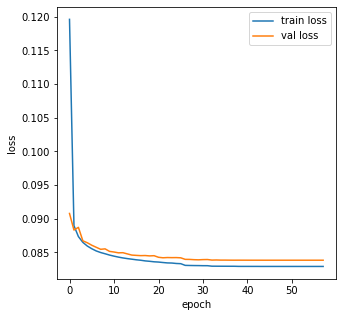

In [16]:
# STEP 3: See loss in function of epochs
plt.figure(figsize=(5,5))
#plt.subplot(121)
plt.plot(r.history['loss'], label ='train loss')
plt.plot(r.history['val_loss'], label ='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
# STEP 4: Peforming the denoising process
denoised_Xtest     = model.predict(X_test)
denoised_Xtest_MLP = MLP.predict(X_test.reshape((-1,28*28)))
#denoised_Xtest_RF  = RF.predict(X_test.reshape((-1,28*28)))

In [18]:
denoised_Xtest.shape, denoised_Xtest_MLP.shape

((10000, 28, 28, 1), (10000, 784))

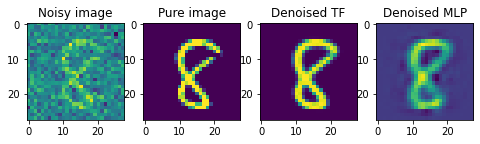

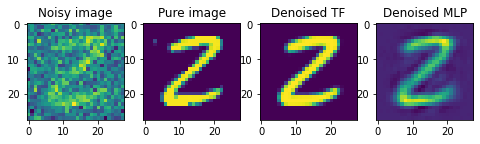

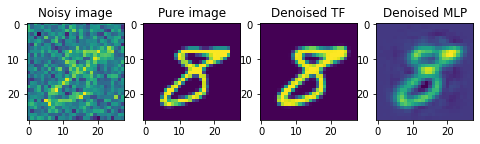

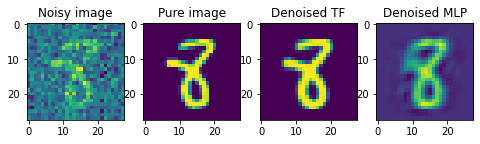

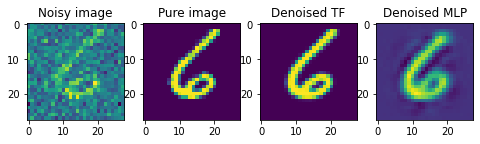

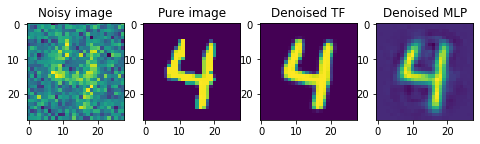

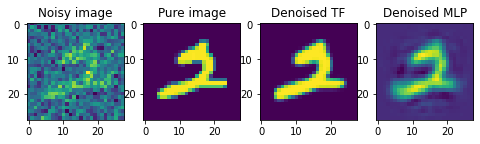

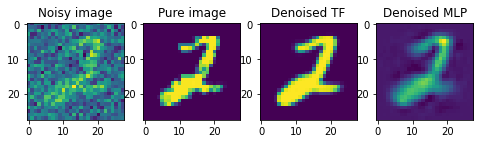

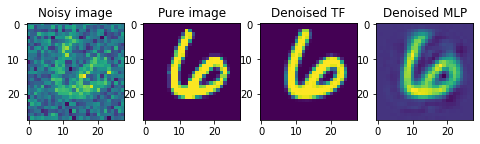

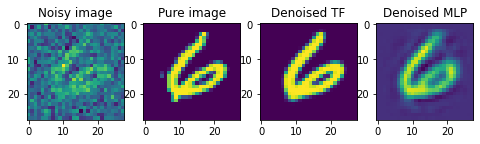

In [25]:
# STEP 5: Plotting noisy, pure and denoised images with TF and MLP
num_vis = 10
random.sample(list(range(len(X_test))), num_vis)
#for i in range(0, num_vis):
for i in random.sample(list(range(len(X_test))), num_vis):
  # Get noisy, pure and the reconstruction images
  noisy_img    = noisy_Xtest[i].reshape((28,28))
  pure_img     = X_test[i].reshape((28,28))
  den_img_TF   = denoised_Xtest[i].reshape((28,28))
  den_img_MLP  = denoised_Xtest_MLP[i].reshape((28,28))
  input_class  = y_test[i]
  # 1x4 grid of images
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(8, 5)
  # Plot noisy, pure and the reconstruction images (TF and MLP)
  axes[0].imshow(noisy_img, cmap = color_mp)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_img, cmap = color_mp)
  axes[1].set_title('Pure image')
  axes[2].imshow(den_img_TF, cmap = color_mp)
  axes[2].set_title('Denoised TF')
  axes[3].imshow(den_img_MLP, cmap = color_mp)
  axes[3].set_title('Denoised MLP')
  #fig.suptitle(f'MNIST target = {input_class}')
  plt.show()

In [20]:
# Done!